# Price Paid Spatial Distribution

*Visualising the spatial distribution of Lower Layer Super Output Area (LSOA) median price paid deciles for residential property sold between 1995 and 2019 for a local authority district (LAD) in England or Wales.*

---

A Jupyter Notebook providing a data science pipeline in Python to leverage data insights through the integration of OS Data Hub APIs with other government data services from the Office for National Statistics and HM Land Registry.

<img width="700"
     src="../media/southampton-local-authority-district-median-price-paid-deciles.png"
     alt="Southampton Local Authority District Median Price Paid Deciles"
     align="centre" />

## Tools and APIs
---

This tutorial sources data from data services (APIs) only. In addition to the APIs made available by Ordnance Survey (OS) through the OS Data Hub, data is sourced from APIs published by HM Land Registry (LR) and the Office for National Statistics (ONS).

**The cells in this notebook that use the OS Data Hub APIs require an API key. Please sign up to the [OS Data Hub](https://osdatahub.os.uk/) and acquire a project API key before attempting to run this notebook locally.**


### Which APIs are used in this notebook?

#### OS Features API

An Open Geospatial Consortium (OGC)-compliant web feature service (WFS) that allows users to query features within a number of OS's premium and open data products.

#### OS Maps API

A web map tile service (WMTS) that allows access to OS base mapping in a number of different styles and two projections, Web Mercator (EPSG: 3857) and British National Grid (EPSG:27700).

#### OS Downloads API

An API enabling users to bulk download OS open data products.

#### ONS Open Geography Portal WFS API

An OGC-compliant WFS that allows users to query features within a number of ONS's open data products.

The [ONS Open Geography Portal](http://geoportal.statistics.gov.uk/) provides access to ONS's open data products.

#### ONS Open Geography Portal ArcGIS REST API

An ESRI API specification that allows users to query features within ONS's open data products.

The [ONS Open Geography Portal](http://geoportal.statistics.gov.uk/) provides access to ONS's open data products.

Please refer to the [ESRI ArcGIS REST API documentation](https://developers.arcgis.com/rest/services-reference/query-feature-service-layer-.htm) for information regarding the ESRI specification.

#### HM LR Linked Data API 

An API enabling users to query HM LR Price Paid Data, Transaction Data and the UK House Price Index.

Please refer to the section **Via the API** within **How to query the dataset** at http://landregistry.data.gov.uk/app/root/doc/ppd for information regarding access to the Price Paid Data through the Linked Data API.

### Python Environment Setup

* The Python geospatial stack used in this tutorial requires the library [**GeoPandas**](http://geopandas.org/).
* The library **fiona** (Python wrapper around the OGR (vector) component of the [Geospatial Data Abstraction Library (GDAL)](https://gdal.org/) is a dependency of GeoPandas.
* The libraries **descartes** and **mapclassify** are not hard GeoPandas dependencies or required imports but are both required for the GeoPandas plot functionality used in this notebook.
* If using the [conda](https://www.anaconda.com/) package manager to create and configure your Python envionment, the libraries **GeoPandas**, **descartes** and **mapclassify** and their dependencies can be installed via: `conda install -n <environment-name> -c conda-forge geopandas descartes mapclassify`

## License
---

This notebook is licensed under the terms of the [MIT License](../LICENSE). 

The datasets sourced via the APIs in this notebook, all of which are set out below, are licensed under the terms of the [Open Government Licence (OGL) v3.0](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/). See [LICENSE](../LICENSE).

Contains OS data © Crown copyright and database right 2020.

Contains National Statistics data © Crown copyright and database right 2020.

Contains HM Land Registry data © Crown copyright and database right 2020.

<img src="http://www.nationalarchives.gov.uk/images/infoman/ogl-symbol-41px-retina-black.png"
     alt="OGL Symbol"
     align="left" />

<br>
<br>

## Tutorial
---

* Step 1 ~ Import Python Libraries
* Step 2 ~ Request LAD boundary from the ONS Open Geography Portal WFS
* Step 3 ~ Construct a URL path for the OS Maps API
* Step 4 ~ Plot LAD boundary returned by the ONS Open Geography Portal WFS on an OS Maps API backed slippy map
* Step 5 ~ Download the OS Open Data product Code-Point Open using the OS Downloads API
* Step 6 ~ Extract the Code-Point Open GPKG from the zipped download
* Step 7 ~ Obtain the data layer name from the Code-Point Open GPKG
* Step 8 ~ Load Code-Point Open layer from GPKG into a GeoDataFrame and reproject from British National Grid to WGS-84
* Step 9 ~ Obtain ESRI JSON geometry representation of LAD boundary to pass to ONS ESRI ArcGIS REST API
* Step 10 ~ Request LSOA Boundaries from the ONS Open Geography Portal ArcGIS REST API
* Step 11 ~ Plot LSOA boundaries returned by the ONS Open Geography Portal ESRI ArcGIS REST API on an OS Maps API backed slippy map
* Step 12 ~ Spatially join postcode and LSOA GeoDataFrames
* Step 13 ~ Transform the postcode strings such that each string has a single space between the outward and inward codes
* Step 14 ~ Request the historical HM LR Price Paid Data for the LAD boundary using the transformed postcode strings associated with the postcode geometries returned from the containment query
* Step 15 ~ Join Price Paid and postcode-LSOA DataFrames and compute median price paid by LSOA by 6 year time windows
* Step 16 ~ Request OS Open ZoomStack district building geometires from the OS Features API for the LAD boundary BBOX
* Step 17 ~ Spatially join and compute the intersection between building polygon geometries and LSOA polygon geometries and, dissolve the resultant buidling features by LSOA code to form an aggregate building geometry per LSOA
* Step 18 ~ Join buidling-LSOA and LSOA-median price paid by 6 year time window DataFrames together on LSOA code
* Step 19 ~ Visualise the spatial distribution in LSOA median price paid decile by 6 year time window
* Step 20 ~ Visualise the change in LSOA median price paid decile between 1995 - 2001 and 2013 - 2019 for LSOAs where the decile position has increased or decreased by two or more places

## Step 1 ~ Import Python Libraries

---

In [6]:
import sys
!{sys.executable} -m pip install folium

     |████████████████████████████████| 102kB 1.5MB/s ta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
!{sys.executable} -m pip install descartes

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import fiona
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile

print('=> Imported libraries')

=> Imported libraries


## Step 2 ~ Request LAD boundary from the ONS Open Geography Portal WFS

---

The example below returns the polygon geometry for a LAD boundary from the ONS Open Geography Portal - Administrative Boundaries - Local Authority Districts open data product. The request is made against the ONS WFS using the OGC WFS filter encoding specification. The Government Statistcal Service (GSS) code for the Southampton boundary **E06000045** is used below. This pipeline can be run for any LAD in England or Wales by changing the GSS code referenced in the filter object.

The request parameters below look to return the feature representing the boundary in **GeoJSON** format using the **WGS-84 (EPSG: 4326)** coordinate reference system.

The ONS Open Geography Portal base path is **https://ons-inspire.esriuk.com**

A [**GetCapabilities**](https://ons-inspire.esriuk.com/arcgis/services/Administrative_Boundaries/Local_Authority_Districts_December_2019_Boundaries_UK_BFE/MapServer/WFSServer?service=wfs&request=GetCapabilities&version=2.0.0) request to the WFS API will return the response codes, content, and parameters of the WFS.

More information regarding the ONS Local Authority Districts product can be found at https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfe

=> Transformed ONS WFS GeoJSON payload into a GeoDataFrame


/Users/iv/.pyenv/versions/3.8.2/envs/jupyter3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


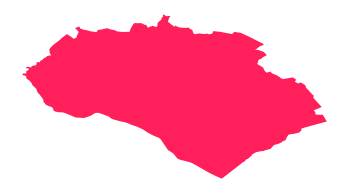

In [3]:
# ONS Open Geography Portal WFS base path: https://ons-inspire.esriuk.com
# ONS WFS endpoint path: /arcgis/services/Administrative_Boundaries
#                        /Local_Authority_Districts_December_2019_Boundaries_UK_BFE
#                        /MapServer/WFSServer?
wfs_endpoint = ('https://ons-inspire.esriuk.com/arcgis/services/Administrative_Boundaries'
                '/Local_Authority_Districts_December_2019_Boundaries_UK_BFE/MapServer/WFSServer?')

# Define WFS parameters 
service = 'wfs'
request = 'GetFeature'
version = '2.0.0'
typeNames = ('Administrative_Boundaries_Wards_December_2019_Boundaries_UK_BFC:'
             'Local_Authority_Districts__December_2019__Full_Extent_Boundaries_UK')
outputFormat = 'GEOJSON'
srsName = 'EPSG:4326'
# Define attribute-based filter using OGC WFS filter encoding specification
# Filter specifies the Government Statistical Service (GSS) Code for the Southampton local authority district area
filter = ('<ogc:Filter>'
              '<ogc:PropertyIsEqualTo>'
                  '<ogc:PropertyName>lad19cd</ogc:PropertyName>'
                  '<ogc:Literal>E06000045</ogc:Literal>'
              '</ogc:PropertyIsEqualTo>'
          '</ogc:Filter>')

# Represent WFS parameters in a dictionary and collapse OGC filter into a single line
params_wfs = {'service':service, 
              'request':request,
              'version':version,
              'typeNames':typeNames,
              'outputFormat':outputFormat,
              'srsName':srsName,
              'filter':filter}

# Make HTTP GET request and raise exception if request was unsuccessful
try:
    r = requests.get(wfs_endpoint, params=params_wfs)
    r.raise_for_status()
except requests.exceptions.RequestException as e:  
    print(e)
    
# Decode JSON payload returned by request    
payload = r.json()

payload
# Define coordinate reference system (CRS) codes
# WGS 84
WGS84 = {'init':'epsg:4326'}
# British National Grid
BNG = {'init':'epsg:27700'}

# Transform GeoJSON features into a GeoPandas GeoDataFrame
gdf_boundary = gpd.GeoDataFrame.from_features(payload['features'], crs=WGS84)

# Obtain polygon centroid point geometry
boundary_centroid = gdf_boundary['geometry'].centroid

# Obtain x and y coordinates of centroid point geometry
x = boundary_centroid.x
y = boundary_centroid.y

# Obtain bounds of polygon geometry
bounds = gdf_boundary['geometry'][0].bounds

# Define a OGC WFS filter compliant bounding box for the polygon geometry
# bottom-left x, bottom-left y, top-right x, top-right y
bbox = str(bounds[0]) + ',' + str(bounds[1]) + ',' + str(bounds[2]) + ',' + str(bounds[3])

# Plot boundary geometry
ax = gdf_boundary.plot(color='#ff1f5b')
# Turn plot axis off
ax.axis('off')

print('=> Transformed ONS WFS GeoJSON payload into a GeoDataFrame')

## Step 3 ~ Construct a URL path for the OS Maps API

---

The OS Data Hub API base path is **https://osdatahubapi.os.uk**

The [technical specification](https://osdatahub.os.uk/docs/wmts/technicalSpecification) for the OS Maps API outlines the response codes, content, and parameters of the WMTS.

The example below constructs a URL path for the OS Data Hub WMTS providing OS base mapping designed for the Leaflet web mapping library. Note, this request will result in an `Execution of Construct-Backend-URL-WMTS failed` exception outside of integration with a web mapping library. The WMTS path specified below returns the **Light** style in a **Web Mercator (EPSG: 3857)** projection. 

The z, y and x variables in the URL within Step 3 represent for an individual tile within the WMTS tile cache, the zoom level (z), tile row (y) and tile column (x) respectively.

Leaflet is able to interpret the tiling scheme for the service and will trigger multiple requests with the required values for the z, y and x variables in order to get the collection of tiles necessary to fill the map extent. 

In [4]:
# OS Maps API (WMTS) endpoint path: /OSMapsAPI/wmts/v1?
wmts_endpoint = 'https://osdatahubapi.os.uk/OSMapsAPI/wmts/v1?'

# Define WMTS parameters 
key = 'FtAS7OR45lE3AR78KxrdGpfYq8uAAV6K'
service = 'wmts'
request = 'GetTile'
version = '2.0.0'
style = 'default'
# Light style base map in Web Mercator projection (EPSG:3857)
layer = 'Light_3857'
tileMatrixSet = 'EPSG:3857'
tileMatrix = 'EPSG:3857:{z}'
tileRow = '{y}'
tileCol ='{x}'

# Represent WMTS parameters in a dictionary
params_wmts = {'key':key, 
              'service':service, 
              'request':request,
              'version':'2.0.0',
              'style':style,
              'layer':layer,
              'tileMatrixSet':tileMatrixSet,
              'tileMatrix':tileMatrix,
              'tileRow':tileRow,
              'tileCol':tileCol}

# Construct WMTS API path
wmts_path = wmts_endpoint + \
           ('key={key}&'
            'service={service}&'
            'request={request}&'
            'version={version}&'
            'style={style}&'
            'layer={layer}&'
            'tileMatrixSet={tileMatrixSet}&'
            'tileMatrix={tileMatrix}&'
            'tileRow={tileRow}&'
            'tileCol={tileCol}').format(**params_wmts)

print('=> Constructed OS Maps API URL: {}'.format(wmts_path))

=> Constructed OS Maps API URL: https://osdatahubapi.os.uk/OSMapsAPI/wmts/v1?key=FtAS7OR45lE3AR78KxrdGpfYq8uAAV6K&service=wmts&request=GetTile&version=2.0.0&style=default&layer=Light_3857&tileMatrixSet=EPSG:3857&tileMatrix=EPSG:3857:{z}&tileRow={y}&tileCol={x}


## Step 4 ~ Plot LAD boundary returned by the ONS Open Geography Portal WFS on an OS Maps API backed slippy map

---

The example below overlays the LAD boundary GeoJSON feature returned by the ONS Open Geography Portal WFS ontop of a Leaflet slippy map using Folium and OS base mapping returned via the OS Data Hub WMTS. The map is centred on the feature using the x and y coordinates of the LAD boundary centroid point geometry. [Folium](https://python-visualization.github.io/folium/#) provides a Python wrapper around the Javascript web mapping library Leaflet.js.

Further WMTS examples can be found at https://labs.os.uk/public/os-data-hub-examples/

<br>

<img width="700"
     src="../media/os-data-hub-os-maps-api-1.png"
     alt="OS Maps API Image 1"
     align="centre" />

In [6]:
# Obtain current date-time
date = datetime.now()

# Create a new Folium map
# Ordnance Survey basemap using the OS Data Hub WMTS centred on the boundary centroid location
# Zoom levels 7 - 16 correspond to the open data zoom scales only
m = folium.Map(location=[y, x],
               min_zoom=7, 
               max_zoom=16,
               tiles=wmts_path,
               attr='Contains OS data © Crown copyright and database right {}'.format(date.year))

# Define feature style function
def style(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#ff1f5b',
            'color': '#ff1f5b',
            'weight': 1,
            'fillOpacity':.3}

# Define feature highlight function
def highlight(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be highlighted on-hover
    """
    return {'weight':3, 
            'color':'#bf1747'}

# Obtain subset of boundary DataFrame
gdf_boundary_subset = gdf_boundary[['lad19cd', 'lad19nm']]

# Transform DataFrame subset to HTML table
html = gdf_boundary_subset.to_html(classes='table table-striped table-hover table-condensed table-responsive')

# Pass HTML table to Folium popup
popup = folium.Popup(html)

# Define feature layer using boundary GeoJSON returned by WFS
overlay = folium.GeoJson(payload, 
                         name=gdf_boundary['lad19nm'],
                         style_function=style,
                         highlight_function=highlight)

# Add popup to map
popup.add_to(overlay)

# Add feature layer to map
overlay.add_to(m)

# Return map object
m

## Step 5 ~ Download the OS Open Data product Code-Point Open using the OS Downloads API

---

The example below downloads the OS open data product **Code-Point Open** for **Great Britain (GB)** in **GeoPackage** format to the current working directory. Code-Point Open data provides all the current postcodes in GB with the easting and northing coordinates of the postcode centroid point geometry. 

We will subsequently:

* Load the postcode data into a GeoDataFrame.
* Reproject the postcode geometries from BNG to WGS-84 so that the CRSs between the postcode dataset and other geospatial datasets are aligned. 
* Join the postcode records to ONS LSOA boundaries for the LAD boundary via a spatial containment query.
* Transform the postcode strings such that each string has a single space between the outward and inward codes.
* Request the historical HM LR Price Paid Data for the LAD boundary using the transformed postcode strings associated with the postcode geometries returned from the containment query.

Using a dataset like Code-Point Open providing current postcodes will serve more than adequently to obtain historical Price Paid Data but in order to obtain the best coverage possible, it may be worth considering using a dataset which lists historical postcodes which are no longer in use such as the [ONS National Statistics Postcode Lookup (NSPL](https://geoportal.statistics.gov.uk/datasets/national-statistics-postcode-lookup-august-2019). The latest NSPL (August 2019) is not available via an API.

In [17]:
# Define OS Data Hub OS Downloads API (download API) parameters
# Specify Code-Point Open product in GeoPackage (GPKG) format
product = 'CodePointOpen'
format = 'GeoPackage'
area = 'GB'
redirect = ''

# OS Downloads API endpoint path: /downloads/v1/products/{product}/downloads?
download_endpoint = 'https://osdatahubapi.os.uk/downloads/v1/products/{}/downloads?'.format(product)

# Represent open data download API parameters in a dictionary
params_download = {'format':format,
                   'area':area,
                   'redirect':redirect}

# Make HTTP GET request and raise exception if request was unsuccessful
# allow_redirects argument set to True in order to trigger file download from API response
try:
    r = requests.get(download_endpoint, params=params_download, allow_redirects=True)
    r.raise_for_status()
except requests.exceptions.RequestException as e:  
    print(e)

# Download zipfile containing Code-Point Open data and documentation to working directory
with open('code-point-open.zip', 'wb') as f:
    f.write(r.content)

print('=> Downloaded Code-Point Open zipfile using the OS Data Hub OS Downloads API')

=> Downloaded Code-Point Open zipfile using the OS Data Hub OS Downloads API


## Step 6 ~ Extract the Code-Point Open GPKG from the zipped download 

---

In [18]:
# Extract GPKG from zipfile to working directory
with ZipFile('code-point-open.zip', 'r') as obj:
    files = obj.namelist()
    # List directories and files in zipfile
    for file in files:
        print(file)
        # Identify file(s) with .gpkg extension
        if file.endswith('.gpkg'):
            obj.extract(file, 'code-point-open')

print('\n=> Extracted GeoPackage in data directory from Code-Point Open zipfile')

readme.txt
data/codepo_gb.gpkg
doc/Code-Point_Open_Column_Headers.csv
doc/Codelist.xlsx
doc/licence.txt
doc/metadata.txt
doc/NHS_Codelist.xls

=> Extracted GeoPackage in data directory from Code-Point Open zipfile


## Step 7 ~ Obtain the data layer name from the Code-Point Open GPKG

---

In [10]:
# Recursively list the working directory
!du -a code-point-open

260352	code-point-open/data/codepo_gb.gpkg
260352	code-point-open/data
260352	code-point-open


In [11]:
# Use Fiona (Python wrapper around the OGR component of the Geospatial Data Abstraction Library (GDAL))
# to list the layers in the GPKG
for layername in fiona.listlayers('code-point-open/data/codepo_gb.gpkg'):
    print(layername)

code_point_open


## Step 8 ~ Load Code-Point Open layer from GPKG into a GeoDataFrame and reproject from British National Grid to WGS-84

---

In [12]:
# Load GPKG layer code_point_open into a GeoPandas GeoDataFrame
gdf_pcd = gpd.read_file('code-point-open/data/codepo_gb.gpkg', layer='code_point_open')

# Set the CRS of the geometry column in the GeoDataFrame to BNG
gdf_pcd.crs = BNG

# Transform the CRS from BNG to WGS84
# Reprojection required so that geometries in pipeline share a common CRS
gdf_pcd = gdf_pcd.to_crs(WGS84)

# Display the head of the GeoDataFrame
gdf_pcd.head()

Postcode  Positional_quality_indicator Country_code NHS_regional_HA_code  \
0  AB101AB                            10    S92000003                 None   
1  AB101AF                            10    S92000003                 None   
2  AB101AG                            10    S92000003                 None   
3  AB101AH                            10    S92000003                 None   
4  AB101AL                            10    S92000003                 None   

  NHS_HA_code Admin_county_code Admin_district_code Admin_ward_code  \
0   S08000020              None           S12000033       S13002842   
1   S08000020              None           S12000033       S13002842   
2   S08000020              None           S12000033       S13002842   
3   S08000020              None           S12000033       S13002842   
4   S08000020              None           S12000033       S13002842   

                                       geometry  
0  POINT (-2.096915928068507 57.14960585555134)  
1  POINT (-2.097806028257344 57.14870686193719)  
2  POINT (-2.096997150706968 57.14906681195888)  
3   POINT (-2.094664298614741 57.1480804670969)  
4  POINT (-2.095411777356433 57.14954413030915)

## Step 9 ~ Obtain ESRI JSON geometry representation of LAD boundary to pass to ONS Open Geography Portal ESRI ArcGIS REST API

---

The [ESRI JSON geometry specifcation](https://developers.arcgis.com/documentation/common-data-types/geometry-objects.htm) outlines how to represent a polygon geometry to pass to the ESRI ArcGIS REST API.

Here we simplify the LAD boundary, reducing its complexity so that it is lighter weight and easier to pass to the API. The coordinate precision of the LAD boundary is also reduced to 3 decimal places.

In [13]:
# Extract Shapely polygon geometry object from GeoDataFrame containing the Southampton local authority district boundary
boundary_geom = gdf_boundary['geometry'][0]

# Simplify the geometry so that it is handled better when passed to the Office for National Statistics (ONS) ArcGIS REST API below
boundary_geom = boundary_geom.simplify(0.001, preserve_topology=False)

# Represent the coordinate pairs of the boundary exterior ring in a list
boundary_ext_coords = list(boundary_geom.exterior.coords)

# Represent a list of coordinate pair lists
boundary_ext_coords = [list(i) for i in boundary_ext_coords]

# Round the coordinate precision for to three decimal places
boundary_ext_coords = np.round(boundary_ext_coords, 3).tolist()

# Obtain a representation of the geometry such that it meets the ESRI JSON geometry object specificaiton
esri_json_geom = str({'rings':[boundary_ext_coords],
                      'spatialReference':{'wkid' : 4326}})

print(esri_json_geom)

{'rings': [[[-1.404, 50.955], [-1.401, 50.955], [-1.402, 50.952], [-1.4, 50.95], [-1.391, 50.949], [-1.388, 50.945], [-1.38, 50.946], [-1.379, 50.947], [-1.37, 50.946], [-1.367, 50.947], [-1.353, 50.94], [-1.358, 50.937], [-1.351, 50.935], [-1.356, 50.93], [-1.352, 50.926], [-1.35, 50.926], [-1.343, 50.922], [-1.338, 50.923], [-1.336, 50.922], [-1.337, 50.921], [-1.332, 50.919], [-1.323, 50.908], [-1.327, 50.906], [-1.326, 50.904], [-1.323, 50.904], [-1.321, 50.9], [-1.334, 50.897], [-1.335, 50.895], [-1.34, 50.894], [-1.342, 50.891], [-1.35, 50.886], [-1.357, 50.884], [-1.375, 50.871], [-1.397, 50.881], [-1.407, 50.892], [-1.419, 50.898], [-1.438, 50.905], [-1.446, 50.902], [-1.461, 50.906], [-1.466, 50.91], [-1.47, 50.917], [-1.478, 50.924], [-1.474, 50.927], [-1.475, 50.928], [-1.473, 50.928], [-1.463, 50.935], [-1.463, 50.938], [-1.455, 50.945], [-1.451, 50.943], [-1.45, 50.944], [-1.449, 50.947], [-1.45, 50.949], [-1.448, 50.949], [-1.44, 50.947], [-1.434, 50.948], [-1.422, 50.947

## Step 10 ~ Request LSOA Boundaries from the ONS Open Geography Portal ArcGIS REST API

---

The example below returns the polygon geometries for the generalised LSOA boundaries contained within the LAD boundary. The request parameters below look to return the features representing the LSOA boundaries in **GeoJSON** format using the **WGS-84 (EPSG: 4326)** coordinate reference system. The LAD boundary represented according to the ESRI JSON geometry specification is buffered by 50 metres prior to the spatial containment query.

=> Transformed ONS ESRI ArcGIS REST API GeoJSON payload into a GeoDataFrame


geometry   lsoa11cd  \
0  POLYGON ((-1.4091 50.9138, -1.4091 50.9136, -1...  E01017136   
1  POLYGON ((-1.4068 50.9145, -1.4068 50.9148, -1...  E01017137   
2  POLYGON ((-1.4065 50.9166, -1.4073 50.9166, -1...  E01017138   
3  POLYGON ((-1.3978 50.9078, -1.3982 50.908, -1....  E01017139   
4  POLYGON ((-1.4126 50.9119, -1.4139 50.9122, -1...  E01017140   

           lsoa11nm  
0  Southampton 023A  
1  Southampton 023B  
2  Southampton 023C  
3  Southampton 029A  
4  Southampton 023D

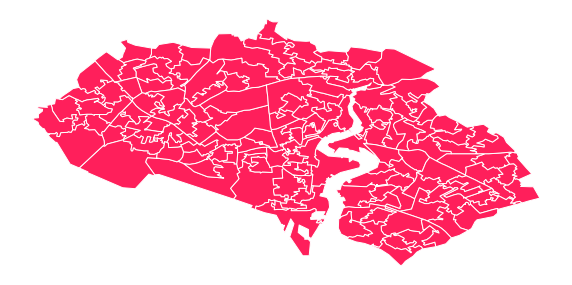

In [14]:
# ONS Open Geography Portal API base path: https://ons-inspire.esriuk.com
# ONS Lower Layer Super Output Area (LSOA) ArcGIS REST API endpoint path: 
# /arcgis/rest/services
# /Census_Boundaries/Lower_Super_Output_Areas_December_2011_Boundaries/MapServer/2/query?
ons_endpoint = ('https://ons-inspire.esriuk.com/arcgis/rest/services'
                '/Census_Boundaries/Lower_Super_Output_Areas_December_2011_Boundaries/MapServer/2/query?')

# Define ONS ESRI ArcGIS REST API parameters
f = 'geojson'
# Pass the ESRI JSON geometry representation from above
geometry = esri_json_geom
geometryType = 'esriGeometryPolygon'
inSR = 4326
# Specify a contains relationship check - which LSOA polygon geometries are contained within the generalised Southampton local authority district boundary
spatialRel = 'esriSpatialRelContains'
# Sepcify a buffer distance of 200 metres for the Southampton local authority district boundary
distance = 200
units = 'esriSRUnit_Meter'
# Return a subset of the LSOA dataset fields - LSOA code, name and geometry
outFields = 'lsoa11cd,lsoa11nm,shape'
# Round coordinate precision in the GeoJSON payload to four decimal places
geometryPrecision = 4
outSR = 4326

# Represent ONS ESRI ArcGIS REST API parameters in a dictionary
params_ons = {'f':f, 
              'geometry':geometry, 
              'geometryType':geometryType,
              'inSR':inSR,
              'spatialRel':spatialRel,
              'distance':distance,
              'units':units,
              'outFields':outFields,
              'geometryPrecision':geometryPrecision,
              'outSR':outSR}

# Make HTTP GET request and raise exception if request was unsuccessful
try:
    r = requests.get(ons_endpoint, params=params_ons)
    r.raise_for_status()
except requests.exceptions.RequestException as e:  
    print(e)

# Decode JSON payload returned by request 
payload = r.json()

# Transform GeoJSON features into a GeoPandas GeoDataFrame
gdf_lsoa = gpd.GeoDataFrame.from_features(payload['features'], crs=WGS84)

print('=> Transformed ONS ESRI ArcGIS REST API GeoJSON payload into a GeoDataFrame')

# Plot LSOA geometries
ax = gdf_lsoa.plot(color='#ff1f5b', edgecolor='#ffffff', figsize=(10, 10))
# Turn plot axis off
ax.axis('off')

# Display head of LSOA GeoDataFrame
gdf_lsoa.head()

## Step 11 ~ Plot LSOA boundaries returned by the ONS Open Geography Portal ESRI ArcGIS REST API on an OS Maps API backed slippy map

---

The example below overlays the GeoJSON feature(s) returned by the ONS ESRI ArcGIS REST API ontop of a Leaflet slippy map using Folium and OS base mapping returned via the OS Data Hub WMTS. The map is centred on the feature using the x and y coordinates of the LAD boundary centroid point geometry. [Folium](https://python-visualization.github.io/folium/#) provides a Python wrapper out the Javascript web mapping libraries Leaflet.js.

<br>

<img width="700"
     src="../media/os-data-hub-os-maps-api-2.png"
     alt="OS Maps API Image 1"
     align="centre" />

In [17]:
# Create a new Folium map
# Ordnance Survey basemap using the OS Data Hub WMTS centred on the boundary centroid location
# Zoom levels 7 - 16 correspond to the open data zoom scales only
m = folium.Map(location=[y, x],
               min_zoom=7, 
               max_zoom=16,
               tiles=wmts_path,
               attr='Contains OS data © Crown copyright and database right {}'.format(date.year))

# Define feature style function
def style(feature):
    return {'fillColor': '#ff1f5b',
            'color': '#ff1f5b',
            'weight': 1,
            'fillOpacity':.3}

# Define feature highlight function
def highlight(feature):
    return {'weight':3, 
            'color':'#bf1747'}

# Obtain subset of LSOA DataFrame
gdf_lsoa_subset = gdf_lsoa[['lsoa11cd', 'lsoa11nm']]

# Transform DataFrame subset to HTML table
html = gdf_lsoa_subset.to_html(classes='table table-striped table-hover table-condensed table-responsive')

# Pass HTML table to Folium popup
popup = folium.Popup(html)

# Define feature layer using LSOA GeoJSON returned by ONS ESRI ArcGIS REST API
overlay = folium.GeoJson(payload, 
                         name='LSOA',
                         style_function=style,
                         highlight_function=highlight)

# Add popup to map
popup.add_to(overlay)

# Add feature layer to map
overlay.add_to(m)

# Return map object
m

## Step 12 ~ Spatially join postcode and LSOA GeoDataFrames

---

Join the postcode GeoDataFrame to the LSOA GeoDataFrame where a postcode point geometry is contained by a LSOA polygon geometry.

In [15]:
# Obtain subset of Code-Point Open postcode GeoDataFrame
gdf_pcd = gdf_pcd[['Postcode', 'geometry']]

# Spatially join the LSOA polygon geometries and Code-Point Open postcode point geometries
gdf_lsoa_pcd = gpd.sjoin(gdf_pcd, gdf_lsoa, how='inner', op='within')

# Obtain count of intersecting postcodes
count = gdf_lsoa_pcd.shape[0]

print('=> Count of intersecting postcodes within Southampton boundary: {}\n'.format(count))

# Display head of LSOA-postcode GeoDataFrame
gdf_lsoa_pcd.head()

=> Count of intersecting postcodes within Southampton boundary: 5806



Postcode                                      geometry  index_right  \
1384030  SO140AA    POINT (-1.39997565531718 50.9070538321384)            3   
1384031  SO140AB  POINT (-1.398580897219752 50.90712759143369)            3   
1384046  SO140AY  POINT (-1.400374668198236 50.90699293377028)            3   
1384159  SO140NF  POINT (-1.401021248125429 50.90758975489555)            3   
1384197  SO140RB  POINT (-1.401021248125429 50.90758975489555)            3   

          lsoa11cd          lsoa11nm  
1384030  E01017139  Southampton 029A  
1384031  E01017139  Southampton 029A  
1384046  E01017139  Southampton 029A  
1384159  E01017139  Southampton 029A  
1384197  E01017139  Southampton 029A

## Step 13 ~ Transform the postcode strings such that each string has a single space between the outward and inward codes

---

In [16]:
# Define postcode format function
# Transform postcode string such that each string has a single space between the outward and inward codes
pcd_format = lambda x:x[0:len(x) - 3].strip() + ' ' + x[len(x) - 3:len(x)]

# Map format function to postcode field in LSOA-postcode GeoDataFrame
gdf_lsoa_pcd['Postcode'] = gdf_lsoa_pcd['Postcode'].map(pcd_format)

# Obtain subset of LSOA-postcode DataFrame
gdf_lsoa_pcd = gdf_lsoa_pcd[['Postcode', 'lsoa11cd']]

print('=> Formatted postcodes')

# Display head of LSOA-postcode DataFrame
gdf_lsoa_pcd['Postcode'].head()

=> Formatted postcodes


1384030    SO14 0AA
1384031    SO14 0AB
1384046    SO14 0AY
1384159    SO14 0NF
1384197    SO14 0RB
Name: Postcode, dtype: object

## Step 14 ~ Request the historical HM LR Price Paid Data for the LAD boundary using the transformed postcode strings associated with the postcode geometries returned from the containment query

---

The example below querys the HM LR Linked Data API to return the historical Price Paid Data for all the postcodes represented in the psotcode-LSOA DataFrame. The Price Paid Data is returned on a postcode-by-postcode basis. 

Each page of the HM LR Price Paid Data API returns a maximum of 10 transaction records per postcode. Therefore, in order to obtain all the historical transactions for a given postcode we need to page through the results using the `_page` parameter. The example assumes a that a single postcode has had no more than 500 transactions since 1995.

The `transactionDate` key value describing the date upon which a property transaction took place is transformed into a Python datetime object assuming the following date time structure:

*Wed, 07 Mar 2001 => '%a, %d %b %Y' => Weekday as locale’s abbreviated name, Day of the month as a zero-padded decimal number, Month as locale’s abbreviated name year and Year with century as a decimal number*.

**The process of obtaining all the historical Price Paid Data for a LAD boundary in England or Wales via the HM LR Linked Data API can take some time ~ 1 hour**

Please refer to the section **Via the API** within **How to query the dataset** at http://landregistry.data.gov.uk/app/root/doc/ppd for information regarding access to the Price Paid Data through the Linked Data API.

In [17]:
# Land Registry (LR) Price Paid Data API base path: http://landregistry.data.gov.uk
# LR Price Paid Data API endpoint path: /data/ppi/transaction-record.json?
lr_end_point = 'http://landregistry.data.gov.uk/data/ppi/transaction-record.json?'

# Create empty list to be populated with price paid transactions
data = []

# Define price paid JSON payload keys to extract
keys = ['propertyAddress', 'transactionId', 'pricePaid', 'transactionDate']

# LR Price Paid API returns a maximum of ten transactions per page
# For each postcode in the Southampton local authority district boundary return all price paid transactions
# Page through the results moving onto the next postcode when no more transactions are returned
# Iterate over the LSOA-postcode DataFrame
for index, row in gdf_lsoa_pcd.iterrows():   
    # Assume that a single postcode has had no more than 500 transactions since 1995
    for i in range(0, 50):  
        # Obtain postcode from lsoa-postcode DataFrame
        propertyAddresspostcode = row['Postcode']
        # Page through the API results
        _page = i
        # Represent LR Price Paid API parameters in a dictionary
        params_lr = {'propertyAddress.postcode':propertyAddresspostcode,
                     '_page':_page}
        # Make HTTP GET request and raise exception if request was unsuccessful
        try:
            r = requests.get(lr_end_point, params=params_lr)
            r.raise_for_status()
        except requests.exceptions.RequestException as e:  
            print(e)
            continue
        # Decode JSON payload returned by request
        payload = r.json()
        # Check if items object is empty
        # If empty move onto next postcode
        if not payload['result']['items']:
            break
        # If not empty append subset of transactions data to data list
        else:
            for j in range(0, len(payload['result']['items'])):
                # Get each transaction record     
                feature = payload['result']['items'][j]
                # Obtain subset of transaction data
                key_dict = {key:feature[key] for key in keys}
                # Obtain postcode from transaction property address
                key_dict['postcode'] = key_dict['propertyAddress']['postcode']
                # Delete property address from data
                del key_dict['propertyAddress']
                # Append data to data list
                data.append(key_dict)

# Convert data list into DataFrame
df_ppd = pd.DataFrame(data)

# Define date format function 
# Required to transform date into Python date-time type
# 
date_format = lambda x:datetime.strptime(x, '%a, %d %b %Y')

# Update transactionDate field by applying date format function
df_ppd['transactionDate'] = df_ppd['transactionDate'].map(date_format)

# Display head of postcode-price paid data DataFrame
df_ppd.head()

transactionId  pricePaid transactionDate  postcode
0  36730F39-F3CD-4C36-A2F0-1CBC84718B39     145000      2005-11-03  SO14 0AA
1  0D709D01-D248-41F1-B16B-424CA2E760AF     145000      2005-11-03  SO14 0AA
2  BAAD42C6-AA07-441D-AC04-5E2468C6A4DB     145000      2005-11-03  SO14 0AA
3  09BF4CFD-3F1B-4933-8A7D-71E4F022E3BF     145000      2005-11-03  SO14 0AA
4  39552709-7B6A-42BE-AAD2-8AE7261C7769     145000      2005-11-03  SO14 0AA

## Step 15 ~ Join Price Paid and postcode-LSOA DataFrames and compute median price paid by LSOA by 6 year time windows

---

In [18]:
# Join LSOA-postocde and postcode-ppd DataFrames together on postcode fields
df_lsoa_ppd = pd.merge(gdf_lsoa_pcd, 
                       df_ppd, 
                       left_on='Postcode',
                       right_on='postcode',
                       how='inner')

# Create new DataFrame field year_group
df_lsoa_ppd['year_group'] = ''

# Update year_group field to represent the 5-year time period a transaction was made in
df_lsoa_ppd.loc[df_lsoa_ppd['transactionDate'] <= '2001-12-31', 'year_group'] = '1995 - 2001' 

df_lsoa_ppd.loc[(df_lsoa_ppd['transactionDate'] >= '2001-01-01') & 
               (df_lsoa_ppd['transactionDate'] <= '2007-12-31'), 'year_group'] = '2001 - 2007' 

df_lsoa_ppd.loc[(df_lsoa_ppd['transactionDate'] >= '2007-01-01') & 
               (df_lsoa_ppd['transactionDate'] <= '2013-12-31'), 'year_group'] = '2007 - 2013' 

df_lsoa_ppd.loc[(df_lsoa_ppd['transactionDate'] >= '2013-01-01') & 
               (df_lsoa_ppd['transactionDate'] <= '2019-12-31'), 'year_group'] = '2013 - 2019'

# Calculate the median price paid by LSOA by year_group
df_lsoa_ppd_yg = df_lsoa_ppd.groupby(['year_group', 'lsoa11cd'])[['pricePaid']].median()

# Display head of median LSOA-year group price paid DataFrame
df_lsoa_ppd_yg.head()

pricePaid
year_group  lsoa11cd            
1995 - 2001 E01017136    93250.0
            E01017137    72250.0
            E01017138    63225.0
            E01017139    45500.0
            E01017140    40000.0

## Step 16 ~ Request OS Open ZoomStack district building geometires from the OS Features API for the LAD boundary BBOX

---

The example below returns the polygon geometries for district building features from the OS open data product OS Open ZoomStack. The request is made against the OS Data Hub WFS using the `bbox` parameter. A bounding box value needs to adhere to the following structure: *bottom-left x, bottom-left y, top-right x, top-right y*.

The OS Data Hub WFS returns a maximum of 100 features per request. Therefore, in order to obtain all of the features for the LAD boundary BBOX, the results are paged through using the `startIndex` parameter which is offset by 100 for each subsequent request.

The request parameters below look to return the features in **GeoJSON** format using the **WGS-84 (EPSG: 4326)** coordinate reference system.

The OS Data Hub API base path is **https://osdatahubapi.os.uk**

The [technical specification](https://osdatahub.os.uk/docs/wfs/technicalSpecification) for the OS Features API outlines the response codes, content, and parameters of the WFS.

Further WFS examples can be found at https://labs.os.uk/public/os-data-hub-examples/

=> Transformed OS Data Hub WFS GeoJSON payload into a GeoDataFrame


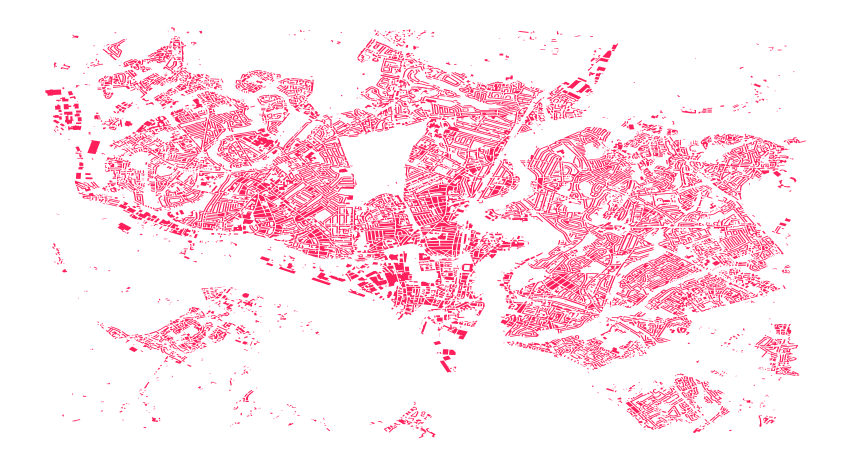

In [36]:
# OS Data Hub WFS endpoint path: /OSFeaturesAPI/wfs/v1?
wfs_endpoint = 'https://osdatahubapi.os.uk/OSFeaturesAPI/wfs/v1?'

# Define WFS parameters
key = key
bbox = bbox
count = 100
service = 'wfs'
request = 'GetFeature'
version = version
typeNames = 'Zoomstack_DistrictBuildings'
outputFormat = 'GEOJSON'
srsName = 'EPSG:4326'

# Create empty list to be populated with building features
features = []

# The OS Data Hub WFS returns a maximum of 100 features per request
#
# The features returned by a spatial filter (in this case BBOX query) 
# can be paged through using the startIndex parameter
#
# The order of features remains constant for a spatial filter
for i in range(0, 60):
    # Offset startIndex value by 100 for each request
    startIndex = i * 100 
    # Represent WFS parameters in a dictionary
    params_wfs = {'key':key,
                  'count':count,
                  'service':service, 
                  'request':request,
                  'version':version,
                  'startIndex':startIndex,
                  'typeNames':typeNames,
                  'outputFormat':outputFormat,
                  'srsName':srsName,
                  'bbox':bbox}
    # Make HTTP GET request and raise exception if request was unsuccessful
    try:
        r = requests.get(wfs_endpoint, params=params_wfs)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print(e)
    # Decode JSON payload returned by request 
    payload = r.json()
    # Check if features object is empty
    # If empty all feature in BBOX have been returned
    if not payload['features']:
        break
    # If not empty append feature data to feature list
    else:
        
        for j in range(0, len(payload['features'])):
            features.append(payload['features'][j])
            
# Represent features in GeoJSON feature collection
geojson = {'type':'FeatureCollection',
           'features':features}

# Transform GeoJSON features into a GeoPandas GeoDataFrame
gdf_build = gpd.GeoDataFrame.from_features(geojson, crs=WGS84)

# Plot building geometries
ax = gdf_build.plot(color='#ff1f5b', figsize=(15, 15))
# Turn plot axis off
ax.axis('off')

print('=> Transformed OS Data Hub WFS GeoJSON payload into a GeoDataFrame')

## Step 17 ~ Spatially join and compute the intersection between building polygon geometries and LSOA polygon geometries and, dissolve the resultant buidling features by LSOA code to form an aggregate building geometry per LSOA

---

In [40]:
# Compute the intersection (shared area) between building geometries and LSOA geometries
gdf_build_lsoa_int = gpd.overlay(gdf_build, gdf_lsoa, how='intersection')

# Delete unnecessary fields from DataFrame
del (gdf_build_lsoa_int['OBJECTID'], 
     gdf_build_lsoa_int['lsoa11nm'], 
     gdf_build_lsoa_int['SHAPE_Length'], 
     gdf_build_lsoa_int['SHAPE_Area'])

# Dissolve / union 'cookie-cut' building geometries by lsoa code
gdf_build_lsoa_diss = gdf_build_lsoa_int.dissolve(by='lsoa11cd')

print('=> Dissolved building geometries by lsoa')

# Display head of GeoDataFrame
gdf_build_lsoa_diss.head()

=> Dissolved building geometries by lsoa


geometry
lsoa11cd                                                    
E01017136  (POLYGON ((-1.410814230645752 50.9090785576614...
E01017137  (POLYGON ((-1.410881112512585 50.9106648900100...
E01017138  (POLYGON ((-1.415566666034249 50.9107999971541...
E01017139  (POLYGON ((-1.399070798319615 50.9004658403360...
E01017140  (POLYGON ((-1.409737269613304 50.8982136519334...

## Step 18 ~ Join buidling-LSOA and LSOA-median price paid by 6 year time window DataFrames together on LSOA code

---

In [41]:
# Join median price paid by LSOA by year group and dissolved buildings by LSOA DataFrames together on LSOA code
df_lsoa_ppd_yg_build = pd.merge(df_lsoa_ppd_yg,
                                gdf_build_lsoa_diss,
                                how='inner',
                                on='lsoa11cd',
                                right_index=True)

# Reset DataFrame index so that LSOA codes are not grouped by year_group values
df_lsoa_ppd_yg_build.reset_index(inplace=True)

# Create GeoPandas GeoDataFrame using dissolved building geometries
# Required as merge operation returns non-geo enabled Pandas DataFrame
gdf_lsoa_ppd_yg_build = gpd.GeoDataFrame(df_lsoa_ppd_yg_build, 
                                         crs=WGS84, 
                                         geometry=df_lsoa_ppd_yg_build['geometry'])

# Display head of GeoDataFrame
gdf_lsoa_ppd_yg_build.head()

year_group   lsoa11cd  pricePaid  \
0  1995 - 2001  E01017136    93250.0   
1  2001 - 2007  E01017136   163000.0   
2  2007 - 2013  E01017136   195000.0   
3  2013 - 2019  E01017136   221750.0   
4  1995 - 2001  E01017137    72250.0   

                                            geometry  
0  (POLYGON ((-1.410814230645752 50.9090785576614...  
1  (POLYGON ((-1.410814230645752 50.9090785576614...  
2  (POLYGON ((-1.410814230645752 50.9090785576614...  
3  (POLYGON ((-1.410814230645752 50.9090785576614...  
4  (POLYGON ((-1.410881112512585 50.9106648900100...

## Step 19 ~ Visualise the spatial distribution in LSOA median price paid decile by 6 year time window

---

The [matplotlib colour map](https://matplotlib.org/examples/color/colormaps_reference.html) used to visualise the spatial distribution in LSOA median price paid decile assigns the bottom decile (lowest median price paid values) to a transparent red colour and the top decile (highest median price paid values) to a purple colour.

Text(0.5, 0.98, 'LSOA Median Price Paid Decile by Six Year Windows')

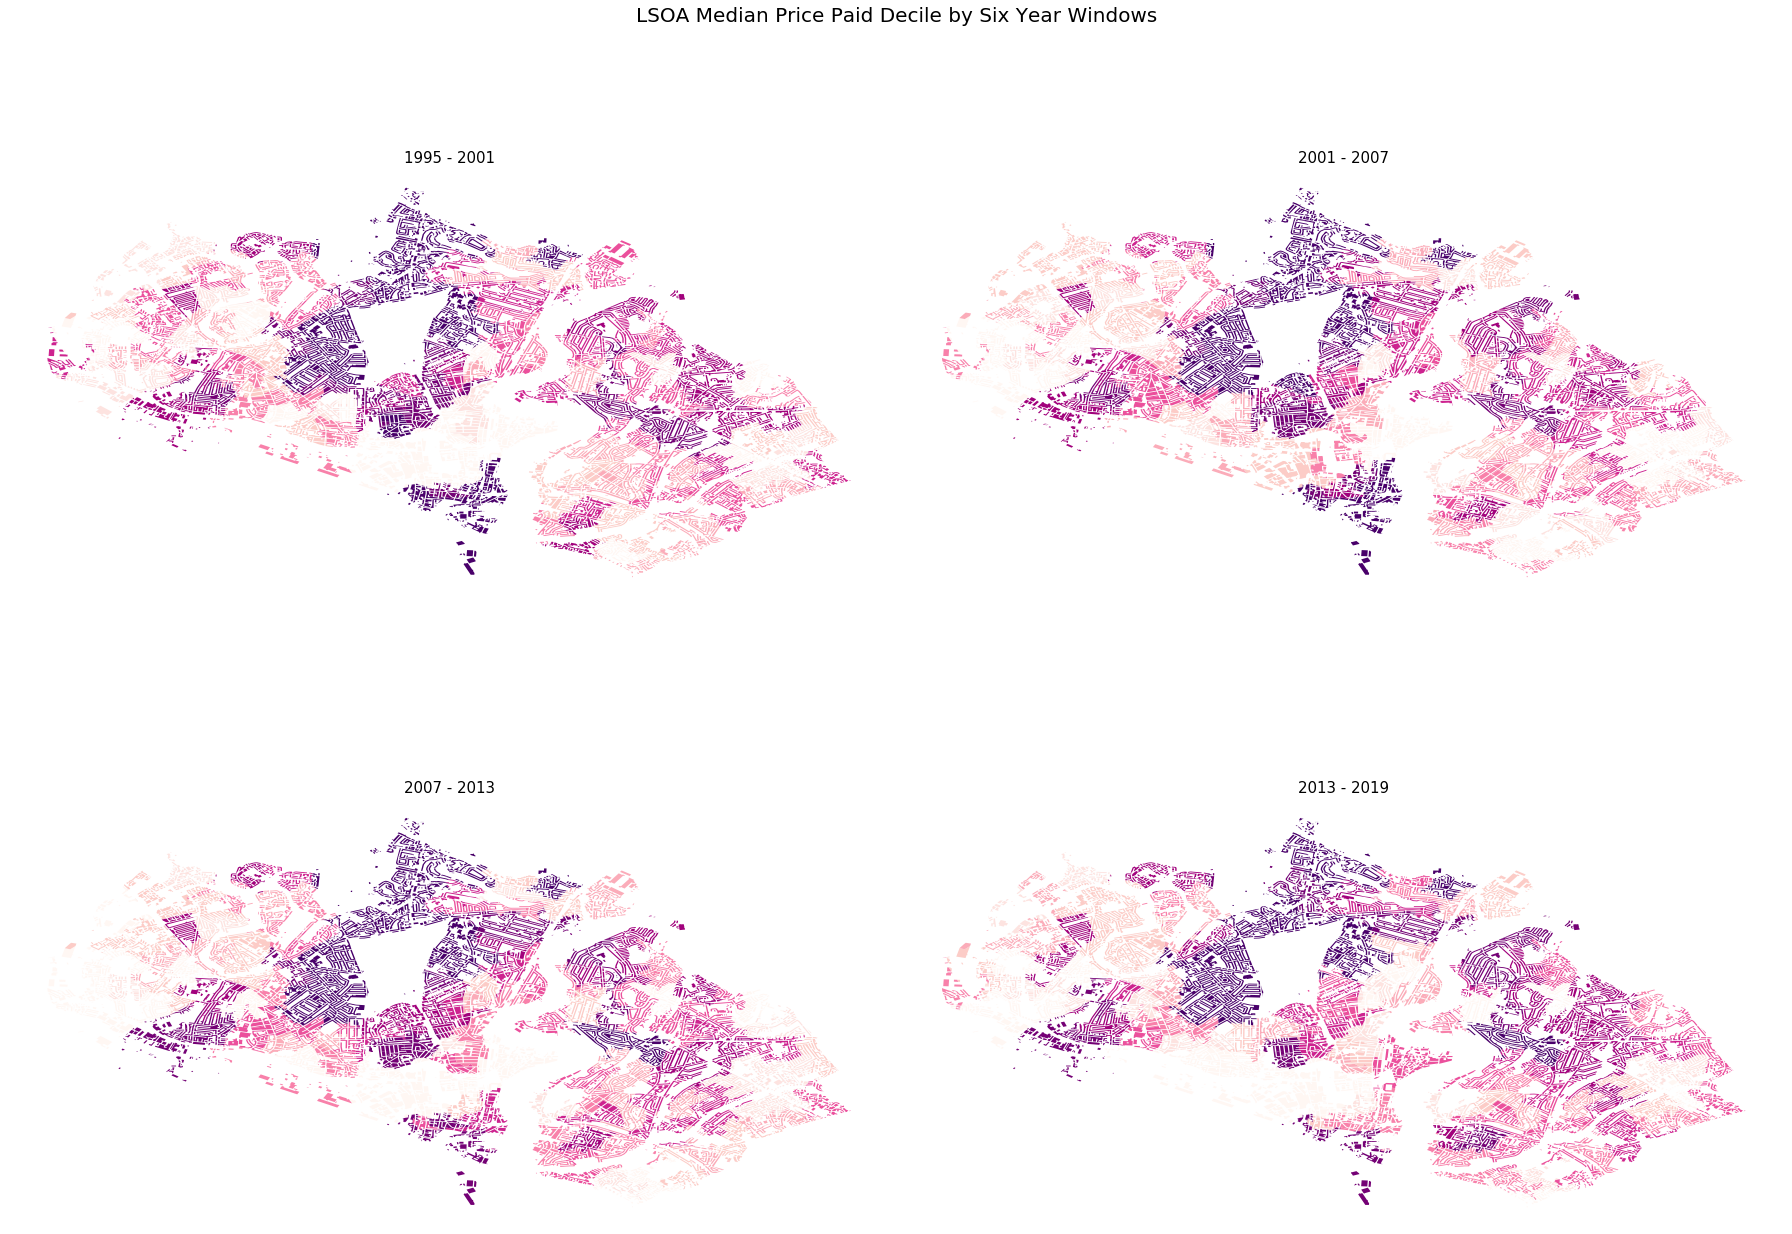

In [42]:
# Obtain distinct values in year_group column
yg_distinct = df_lsoa_ppd_yg_build['year_group'].unique()

# Define matplotlib subplots object with 2 rows and 2 columns
fig, ax = plt.subplots(2, 2, figsize=(25, 20))

# Flatten axes so that it can be accessed with a single integer index
ax = ax.flatten()

# For each distinct year_group value plot a choropleth map where the dissolved building geometries describe
# the median price paid by decile
for i, value in enumerate(yg_distinct):
    # Get subset of GeoDataFrame corresponding to a year_group
    gdf_lsoa_ppd_yg_build_subset = gdf_lsoa_ppd_yg_build[gdf_lsoa_ppd_yg_build['year_group']==value]
    # Create choropleth map for subset and assign to subplots axes index
    # Calculate median price paid deciles using Quantile scheme and 10 classes
    ax[i] = gdf_lsoa_ppd_yg_build_subset.plot(column=gdf_lsoa_ppd_yg_build_subset['pricePaid'],
                                              ax=ax[i], 
                                              scheme='Quantiles', 
                                              k=10, 
                                              linewidth=0, 
                                              cmap='RdPu')
    # Turn plot axes off
    ax[i].axis('off')
    # Display a title for each subplot corresponding to the year_group
    ax[i].set_title(value, fontsize=15)

# Force a tight layout for the overall plot
plt.tight_layout()

# Display main figure title
plt.suptitle('LSOA Median Price Paid Decile by Six Year Windows', fontsize=20)

## Step 20 ~ Visualise the change in LSOA median price paid decile between 1995 - 2001 and 2013 - 2019 for LSOAs where the decile position has increased or decreased by two or more places

---

Text(0.5, 1, 'Change in LSOA Median Price Paid Decile 1995 - 2001 vs 2013 - 2019')

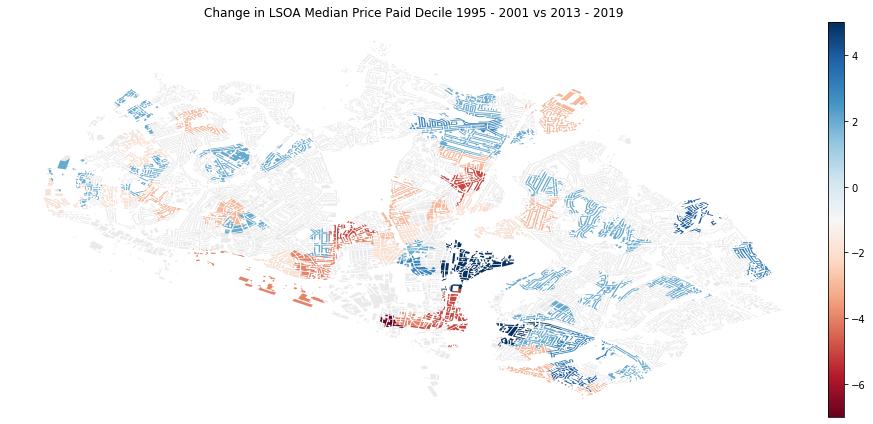

In [43]:
# Define ntile function deriving LSOA median price paid decile by year_group
ntile = lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))

# Apply ntile function
gdf_lsoa_ppd_yg_build['decile'] = gdf_lsoa_ppd_yg_build.groupby(['year_group'])['pricePaid'].transform(ntile)

# Obtain data pertaining to the year_group value '1995 - 2000'
df_yg_1995_2001 = gdf_lsoa_ppd_yg_build[gdf_lsoa_ppd_yg_build['year_group']=='1995 - 2001']

# Obtain data pertaining to the year_group value '1995 - 2000'
df_yg_2013_2019 = gdf_lsoa_ppd_yg_build[gdf_lsoa_ppd_yg_build['year_group']=='2013 - 2019']

# Join median df_yg_1995_2000 and df_yg_2015_2020 DataFrames together on LSOA code
df_yg_merge = pd.merge(df_yg_1995_2001,
                       df_yg_2013_2019,
                       how='inner',
                       on='lsoa11cd',
                       suffixes=('_1995_2001', '_2013_2019'))

# Compute change in LSOA median price paid decile 
# Negative change represnts a decrease in median price paid value 
# Positive change represents an increase in median price paid value
df_yg_merge['decile_change'] = df_yg_merge['decile_2013_2019'] - df_yg_merge['decile_1995_2001']

# Obtain LSOAs which have moved two or more deciles
df_yg_merge_churn = df_yg_merge.loc[abs(df_yg_merge['decile_change']) > 1, ['lsoa11cd', 'decile_change', 'geometry_1995_2001']]

# Convert DataFrame into a GeoPandas GeoDataFrame to plot
gdf_yg_merge_churn = gpd.GeoDataFrame(df_yg_merge_churn, 
                                      crs=WGS84, 
                                      geometry=df_yg_merge_churn['geometry_1995_2001'])

# Create base plot representing building geometry for the Southampton boundary
base = gdf_build_lsoa_diss.plot(color='#eaeaea', figsize=(15, 15))

# Enable legend configurability
divider = make_axes_locatable(base)

# Define legend configuration
cax = divider.append_axes('right', size='2%', pad=0.1)

# Plot LSOAs which have moved two or more deciles ontop of the contextual base
# Red represents decile decrease
# Blue represents decile increase
gdf_yg_merge_churn.plot(ax=base, column=df_yg_merge_churn['decile_change'], cmap='RdBu', legend=True, cax=cax)

# Turn plot axis off
base.axis('off')

# Define plot title
base.set_title('Change in LSOA Median Price Paid Decile 1995 - 2001 vs 2013 - 2019')